# Basic Analysis

In [32]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from dateutil.parser import parse
import re

In [33]:
curr=os.getcwd()
parent_path=os.path.dirname(curr)
data_path=parent_path+'\Dataset'


In [34]:
dataset=pd.read_csv(data_path+'\FineTech_appData.csv')
dataset.head(3)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1


In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user                  50000 non-null  int64 
 1   first_open            50000 non-null  object
 2   dayofweek             50000 non-null  int64 
 3   hour                  50000 non-null  object
 4   age                   50000 non-null  int64 
 5   screen_list           50000 non-null  object
 6   numscreens            50000 non-null  int64 
 7   minigame              50000 non-null  int64 
 8   used_premium_feature  50000 non-null  int64 
 9   enrolled              50000 non-null  int64 
 10  enrolled_date         31074 non-null  object
 11  liked                 50000 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 4.6+ MB


* So there are in total 50000 records and only "enrolled_date" is the one which is having missing values

In [36]:
miss_for_noenroll_condition=(dataset['enrolled']==1)&(dataset['enrolled_date'].isnull())
print("Enrolled records without enrolled dates:",len(dataset[miss_for_noenroll_condition]))

Enrolled records without enrolled dates: 0


* Thus we can conclude that there's no missing records

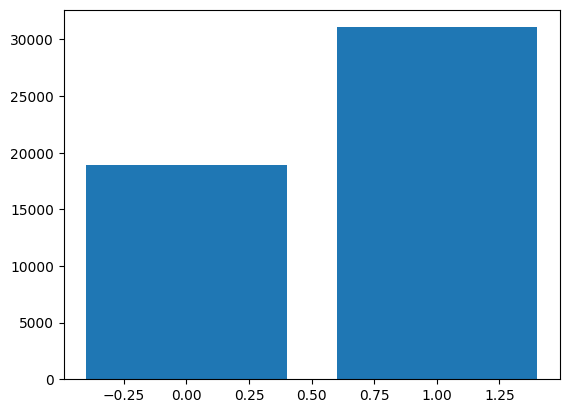

Enrolled vs Not Enrolled
enrolled
1    31074
0    18926
Name: count, dtype: int64


In [37]:
plt.bar(dataset['enrolled'].value_counts().index,dataset['enrolled'].value_counts())
plt.show()
print("Enrolled vs Not Enrolled")
print(dataset['enrolled'].value_counts())


* But we see highly imbalanced data by above graph

In [38]:
dataset['hour']=dataset.hour.str.slice(1,3).astype('int')

In [39]:
dataset.head(5)



,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [40]:
non_num_col=['user','first_open','screen_list','enrolled_date','enrolled']
dataset_num=dataset.copy().drop(non_num_col,axis=1)

<Figure size 640x480 with 0 Axes>

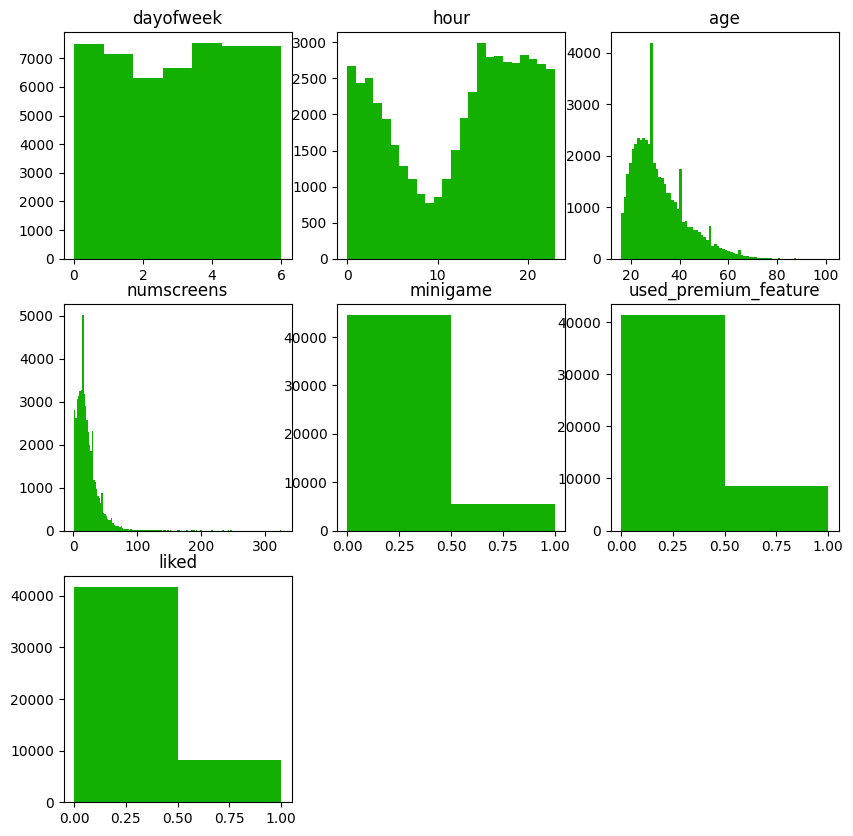

In [41]:
#Let's plot a histogram of numerical columns for analysis
plt.suptitle('Histogram of Numerical Columns',fontsize=15) #Setting up the canvas
plt.figure(figsize=(10,10))
for i in range(1,dataset_num.shape[1]+1):
    plt.subplot(3,3,i) #Since we've 7 cols in total, 9 subplots would be fine
    f=plt.gca()     #Setting up the instance for current axes within the subplot
    f.set_title(dataset_num.columns.values[i-1])
    vals=np.size(dataset_num.iloc[:,i-1].unique()) #Calculating bins value by knowing the unique values of a column
    plt.hist(dataset_num.iloc[:,i-1],bins=vals,color='#13AF01')

plt.show()

<b> Observations from the above plot :</b>
* Day of the week has almost the same count of observations
* We see a sharp decrease at around 10am in Hour plot. Mark that this hour time is recorded in UTC and in PST this means somewhere around at 3am which is when people are sleeping in night. Hence, it makes sense.
* Age plot shows that most of the people using the app are young generation.
* And also the number of screen customers are using majorly is somewhere between 1 to 50.

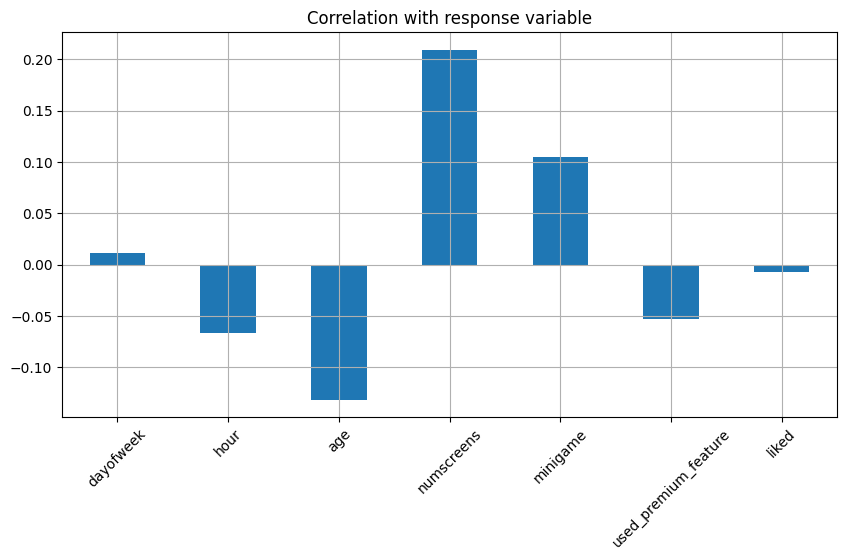

In [42]:
## Correlation with Response variable
dataset_num.corrwith(dataset['enrolled']).plot.bar(figsize=(10,5),
                                                   title='Correlation with response variable' 
                                                   ,fontsize=10, rot=45,grid=True)
plt.show()

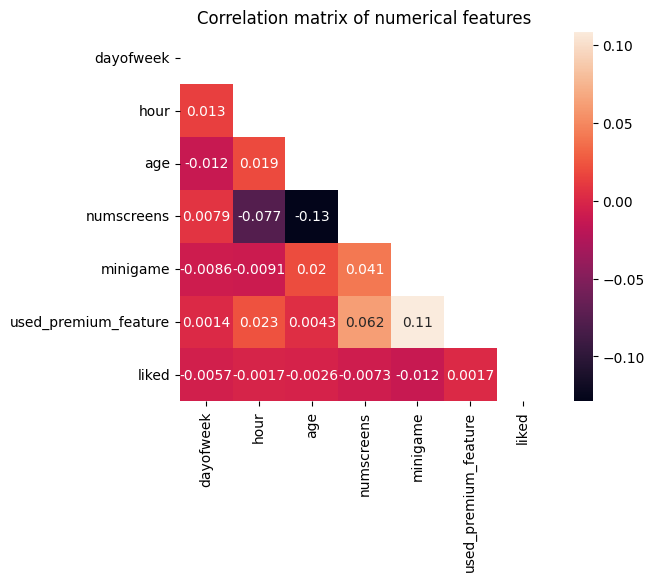

In [43]:
corr_num=dataset_num.corr()
#Creating mask
mask=np.triu(np.ones_like(corr_num))
sns.heatmap(corr_num,annot=True,square=True,mask=mask)
plt.title("Correlation matrix of numerical features")
plt.show()

### Observations:
* We see strong positive correlation between minigame and user_premium_feature.
* We see strong negative correlation between age and numscreens.

### Feature Engineering

In [44]:
dataset.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                     int32
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

In [45]:
dataset['first_open']=[parse(row_data) if(isinstance(row_data,str)) else row_data for row_data in dataset['first_open']]
dataset['enrolled_date']=[parse(row_data) if(isinstance(row_data,str)) else row_data for row_data in dataset['enrolled_date']]
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int32
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

In [46]:
dataset['difference']=(dataset['enrolled_date']-dataset['first_open']).astype('timedelta64[ms]').dt.total_seconds()/3600
dataset[dataset['enrolled']==1].head(3)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,difference
3,234192,2013-07-05 16:08:46.354,4,16,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0,0.050877
4,51549,2013-02-26 18:50:48.661,1,18,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1,0.096994
5,56480,2013-04-03 09:58:15.752,2,9,20,"idscreen,Cycle,Home,ScanPreview,VerifyPhone,Ve...",14,0,0,1,2013-04-03 09:59:03.291,0,0.013205


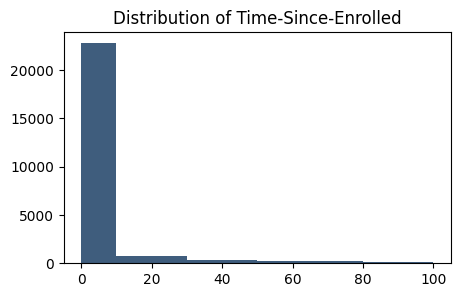

In [47]:
plt.figure(figsize=(5,3))
plt.hist(dataset['difference'].dropna(),color='#3F5D7D',range=[0,100])
plt.title("Distribution of Time-Since-Enrolled")
plt.show()

### Observation:
* We see that first most the persons who bought the subscription were the one's who got enrolled withing first 10 hours of opening the app.

In [48]:
dataset['is_weekend_firstopen']=[1 if(row_data.weekday()>=5)else 0 for row_data in dataset['first_open']]
dataset['is_weekend_enrolleddate']=[1 if(row_data.weekday()>=5) else 0 for row_data in dataset['enrolled_date']]
dataset.head(3)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,difference,is_weekend_firstopen,is_weekend_enrolleddate
0,235136,2012-12-27 02:14:51.273,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaT,0,NaN,0,0
1,333588,2012-12-02 01:16:00.905,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaT,0,NaN,1,0
2,254414,2013-03-19 19:19:09.157,1,19,23,"Splash,Cycle,Loan",3,0,1,0,NaT,1,NaN,0,0


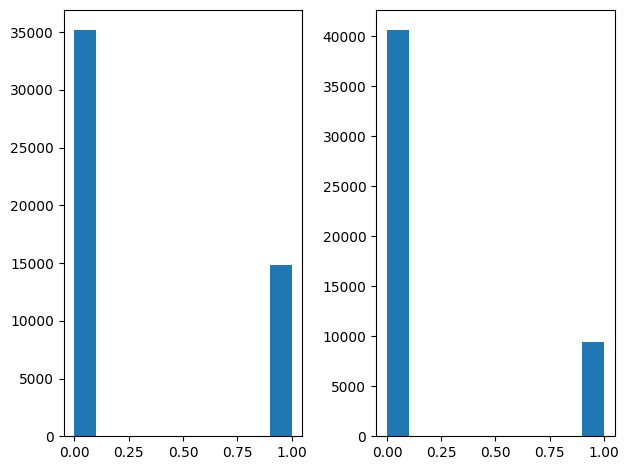

In [49]:
plt.subplot(1,2,1)
plt.hist(dataset['is_weekend_firstopen'])
plt.subplot(1,2,2)
plt.hist(dataset['is_weekend_enrolleddate'])
plt.tight_layout()

In [50]:
dataset.loc[dataset['difference']>48,'enrolled']=0
dataset=dataset.drop(columns=['difference','enrolled_date','first_open'])

In [51]:
dataset.head(3)

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,liked,is_weekend_firstopen,is_weekend_enrolleddate
0,235136,3,2,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0,0,0
1,333588,6,1,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,1,0
2,254414,1,19,23,"Splash,Cycle,Loan",3,0,1,0,1,0,0


#### Fetching top screens

In [52]:
top_scrn_df=pd.read_csv(data_path+'\\top_screens.csv').top_screens.values
dataset["screen_list"]=dataset.screen_list.astype(str)+',' 
for scn in top_scrn_df:
    dataset[scn]=dataset.screen_list.str.contains(scn).astype(int)
    dataset['screen_list']=dataset.screen_list.str.replace(scn+',',"")
dataset["Other"]=dataset.screen_list.str.count(",")
dataset=dataset.drop(columns=['screen_list'])

In [53]:
dataset.shape

(50000, 70)

In [54]:
dataset.head(5)

,user,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,is_weekend_firstopen,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,Other
0,235136,3,2,23,15,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,1,24,13,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19,23,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16,28,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18,31,32,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,10


In [55]:
#CC Columns
cc_pattern=r'^CC'
CC_cols=[a for a in dataset.columns.values if re.search(string=a,pattern=cc_pattern)]
CC_cols


['CC1Category', 'CC1', 'CC3']

In [56]:
#Loan Columns
loan_pattern=r'^Loan'
loan_cols=[a for a in dataset.columns.values if re.search(string=a,pattern=loan_pattern)]
loan_cols

['Loan2', 'Loan3', 'Loan', 'Loan4']

In [59]:
#Savings columns
save_pattern=r'^Saving'
save_cols=[a for a in dataset.columns.values if re.search(string=a,pattern=save_pattern)]
save_cols

['Saving9',
 'Saving1',
 'Saving8',
 'Saving10',
 'Saving4',
 'Saving7',
 'Saving2',
 'Saving6',
 'Saving2Amount',
 'Saving5']

In [61]:
#Combined CC columns
dataset['CC']=dataset[CC_cols].sum(axis=1)
#Combined Loan columns
dataset['Loan_all']=dataset[loan_cols].sum(axis=1)
#Combined Saving columns
dataset['Saving']=dataset[save_cols].sum(axis=1)

In [64]:
dataset.drop(CC_cols,axis=1,inplace=True)
dataset.drop(loan_cols,axis=1,inplace=True)
dataset.drop(save_cols,axis=1,inplace=True)

In [66]:
dataset.shape

(50000, 56)

## Data Pre-Processing